In [2]:
import sys
import penaltyblog as pb
sys.path.append("../../")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

df = pd.read_csv("PL18.csv", sep=';')
df.head()

,Date,Home,Away,HG,AG
0,11/08/2017,Arsenal,Leicester,4,3
1,12/08/2017,Brighton,Man City,0,2
2,12/08/2017,Chelsea,Burnley,2,3
3,12/08/2017,Crystal Palace,Huddersfield,0,3
4,12/08/2017,Everton,Stoke,1,0


# Custom functions

In [3]:
def simulate_season(sim, model):
    for index, row in sim.iterrows():
        home_team = row['Home']
        away_team = row['Away']
        
        probs = model.predict(home_team, away_team)
        home_goal_expectation = probs.home_goal_expectation
        away_goal_expectation = probs.away_goal_expectation
        
        home_goals = np.random.poisson(home_goal_expectation)
        away_goals = np.random.poisson(away_goal_expectation)
        
        sim.at[index, 'HG'] = home_goals
        sim.at[index, 'AG'] = away_goals

    sim['HG'] = sim['HG'].astype(int)
    sim['AG'] = sim['AG'].astype(int)

    return sim

def calculate_standings(sim):
    team_stats = {}

    for index, row in sim.iterrows():
        home_team = row['Home']
        away_team = row['Away']
        home_goals = row['HG']
        away_goals = row['AG']
        
        # Update or initialize stats for home team
        if home_team in team_stats:
            team_stats[home_team]['GF'] += home_goals
            team_stats[home_team]['GA'] += away_goals
            team_stats[home_team]['GD'] += (home_goals - away_goals)
            team_stats[home_team]['PTS'] += (3 if home_goals > away_goals else (1 if home_goals == away_goals else 0))
            team_stats[home_team]['P'] += 1
        
            if home_goals > away_goals:
                team_stats[home_team]['W'] += 1
            elif home_goals == away_goals:
                team_stats[home_team]['D'] += 1
            else:
                team_stats[home_team]['L'] += 1
        else:
            team_stats[home_team] = {'GF': home_goals, 'GA': away_goals, 'GD': (home_goals - away_goals),
                                    'PTS': (3 if home_goals > away_goals else (1 if home_goals == away_goals else 0)),
                                    'P': 1, 'W': 1 if home_goals > away_goals else 0,
                                    'D': 1 if home_goals == away_goals else 0, 'L': 1 if home_goals < away_goals else 0}

        # Update or initialize stats for away team
        if away_team in team_stats:
            team_stats[away_team]['GF'] += away_goals
            team_stats[away_team]['GA'] += home_goals
            team_stats[away_team]['GD'] += (away_goals - home_goals)
            team_stats[away_team]['PTS'] += (3 if away_goals > home_goals else (1 if away_goals == home_goals else 0))
            team_stats[away_team]['P'] += 1
            
            if away_goals > home_goals:
                team_stats[away_team]['W'] += 1
            elif away_goals == home_goals:
                team_stats[away_team]['D'] += 1
            else:
                team_stats[away_team]['L'] += 1
        else:
            team_stats[away_team] = {'GF': away_goals, 'GA': home_goals, 'GD': (away_goals - home_goals),
                                    'PTS': (3 if away_goals > home_goals else (1 if away_goals == home_goals else 0)),
                                    'P': 1, 'W': 1 if away_goals > home_goals else 0,
                                    'D': 1 if away_goals == home_goals else 0, 'L': 1 if away_goals < home_goals else 0}

    standings = pd.DataFrame.from_dict(team_stats, orient='index')
    standings.index.name = 'Team'

    # Calculate additional stats like Goal Difference, Wins, Draws, Losses, and Points Percentage
    standings['GD'] = standings['GF'] - standings['GA']
    standings['%'] = round((standings['PTS'] / (standings['P'] * 3)) * 100, 1)

    # Sort the standings by Points, Goal Difference, and Goals For
    standings = standings.sort_values(by=['PTS', 'GD', 'GF'], ascending=False)

    # Add Position (Pos) column
    standings.reset_index(inplace=True)
    standings['Pos'] = standings.index + 1
    standings.set_index('Pos', inplace=True)
    standings.index.name = 'Pos'
    standings = standings[['Team', 'PTS', 'P', 'W', 'D', 'L', 'GF', 'GA', 'GD', '%']]
    standings.reset_index(inplace=True)

    return standings

def euclidean_distance(df1, df2):
    if df1.shape != df2.shape:
        raise ValueError("Dataframes must have the same shape")

    # Calculate squared differences element-wise
    squared_diff = (df1 - df2) ** 2

    # Calculate RMSE (square root of mean of squared differences)
    rmse = np.sqrt(np.mean(squared_diff.values))
    return rmse

# Dixon Coles

In [4]:
dc = pb.models.DixonColesGoalModel(df["HG"], df["AG"], df["Home"], df["Away"])
dc.fit()
dc

Module: Penaltyblog

Model: Dixon and Coles

Number of parameters: 42
Log Likelihood: -1050.801
AIC: 2185.601

Team                 Attack               Defence             
------------------------------------------------------------
Arsenal              1.448                -0.906              
Bournemouth          0.956                -0.759              
Brighton             0.685                -0.895              
Burnley              0.698                -1.227              
Chelsea              1.257                -1.22               
Crystal Palace       0.949                -0.854              
Everton              0.938                -0.81               
Huddersfield         0.489                -0.826              
Leicester            1.19                 -0.755              
Liverpool            1.564                -1.176              
Man City             1.786                -1.516              
Man United           1.331                -1.518              
Newcastle

## Simulating a match

In [27]:
num_simulations = 1000
home_team = "Man City"
away_team = "Stoke"

probs = dc.predict(home_team, away_team)
home_goal_expectation = probs.home_goal_expectation
away_goal_expectation = probs.away_goal_expectation

print(home_team, "xG -", home_goal_expectation)
print(away_team, "xG -", away_goal_expectation)

poisson_home_goals = np.random.poisson(home_goal_expectation)
poisson_away_goals = np.random.poisson(away_goal_expectation)

print("\nMATCH SIMULATION")
print(home_team, "-", poisson_home_goals)
print(away_team, "-", poisson_away_goals)

Man City xG - 4.128779039593104
Stoke xG - 0.4510392029975143

MATCH SIMULATION
Man City - 1
Stoke - 0


## Simulating a match 1000 times

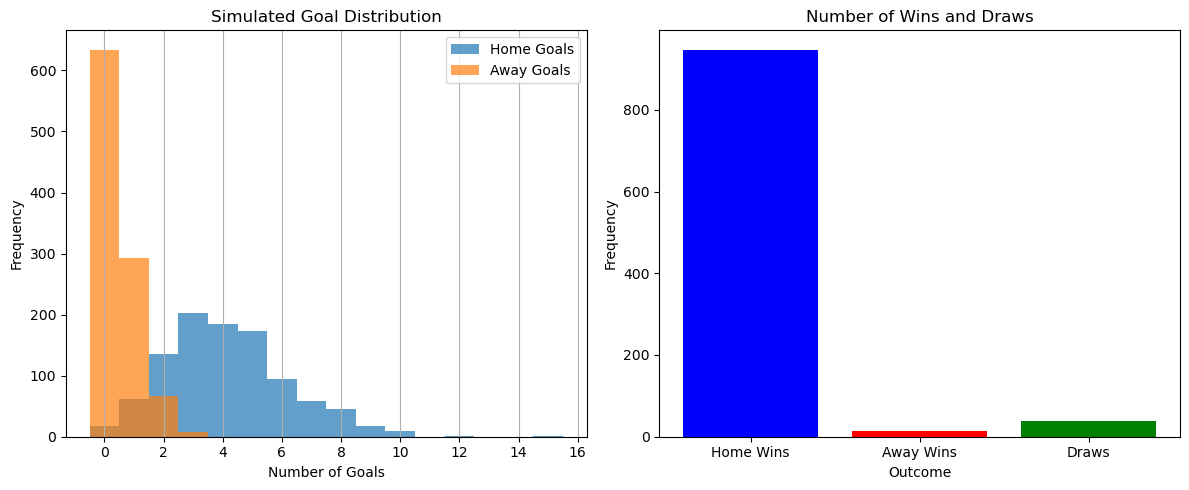

In [28]:
home_goals_simulated = np.random.poisson(home_goal_expectation, num_simulations)
away_goals_simulated = np.random.poisson(away_goal_expectation, num_simulations)

home_wins = np.sum(home_goals_simulated > away_goals_simulated)
away_wins = np.sum(home_goals_simulated < away_goals_simulated)
draws = np.sum(home_goals_simulated == away_goals_simulated)

# Plotting the distributions
plt.figure(figsize=(12, 5))

# Plotting goal distributions
plt.subplot(1, 2, 1)
plt.hist(home_goals_simulated, bins=np.arange(-0.5, max(home_goals_simulated) + 1.5, 1), alpha=0.7, label='Home Goals')
plt.hist(away_goals_simulated, bins=np.arange(-0.5, max(away_goals_simulated) + 1.5, 1), alpha=0.7, label='Away Goals')
plt.xlabel('Number of Goals')
plt.ylabel('Frequency')
plt.title('Simulated Goal Distribution')
plt.legend()
plt.grid(True, axis='x')

# Plotting win counts
plt.subplot(1, 2, 2)
labels = ['Home Wins', 'Away Wins', 'Draws']
values = [home_wins, away_wins, draws]
plt.bar(labels, values, color=['blue', 'red', 'green'])
plt.xlabel('Outcome')
plt.ylabel('Frequency')
plt.title('Number of Wins and Draws')

plt.tight_layout()
plt.show()

## Simulating the championship

In [29]:
sim = df[['Home', 'Away']].copy()
sim.head()

,Home,Away
0,Arsenal,Leicester
1,Brighton,Man City
2,Chelsea,Burnley
3,Crystal Palace,Huddersfield
4,Everton,Stoke


In [38]:
sim_matches_dc = simulate_season(sim, dc)
sim_standings_dc = calculate_standings(sim_matches_dc)
sim_standings_dc

,Pos,Team,PTS,P,W,D,L,GF,GA,GD,%
0,1,Man City,93,38,29,6,3,90,33,57,81.6
1,2,Man United,92,38,28,8,2,81,23,58,80.7
2,3,Chelsea,80,38,23,11,4,66,25,41,70.2
3,4,Tottenham,70,38,21,7,10,79,39,40,61.4
4,5,Liverpool,70,38,21,7,10,77,41,36,61.4
5,6,Arsenal,61,38,18,7,13,73,56,17,53.5
6,7,Leicester,56,38,16,8,14,61,56,5,49.1
7,8,Southampton,52,38,14,10,14,46,55,-9,45.6
8,9,Everton,51,38,15,6,17,40,57,-17,44.7
9,10,West Ham,49,38,14,7,17,49,78,-29,43.0


## Simulating the championship 1000 times

In [39]:
all_standings_dc = []
num_simulations = 100

for i in range(num_simulations):
    matches = simulate_season(sim, dc)
    standings = calculate_standings(matches)
    all_standings_dc.append(standings)

# Now calculate the average standings
average_standings_dc = pd.concat(all_standings_dc).groupby('Team').mean().reset_index()

# Sort the average standings by Points, Goal Difference, and Goals For
average_standings_dc = average_standings_dc.sort_values(by=['PTS', 'GD', 'GF'], ascending=False)

# Add Position (Pos) column
average_standings_dc['Pos'] = average_standings_dc.index + 1
average_standings_dc.set_index('Pos', inplace=True)
average_standings_dc.index.name = 'Pos'
average_standings_dc = average_standings_dc[['Team', 'PTS', 'P', 'W', 'D', 'L', 'GF', 'GA', 'GD', '%']]
average_standings_dc.reset_index(drop=True, inplace=True)

# Display the average standings
average_standings_dc

,Team,PTS,P,W,D,L,GF,GA,GD,%
0,Man City,94.73,38.0,30.03,4.64,3.33,107.40,26.18,81.22,83.099
1,Liverpool,81.09,38.0,24.79,6.72,6.49,87.02,37.13,49.89,71.133
2,Man United,78.77,38.0,23.59,8.00,6.41,66.79,26.98,39.81,69.093
3,Tottenham,75.82,38.0,22.63,7.93,7.44,73.04,35.42,37.62,66.507
4,Chelsea,67.40,38.0,19.42,9.14,9.44,60.26,38.09,22.17,59.123
5,Arsenal,66.80,38.0,19.82,7.34,10.84,74.10,51.82,22.28,58.597
6,Leicester,52.29,38.0,14.66,8.31,15.03,56.51,60.00,-3.49,45.870
7,Crystal Palace,47.92,38.0,12.83,9.43,15.74,45.04,54.70,-9.66,42.037
8,Burnley,47.75,38.0,12.11,11.42,14.47,34.36,39.00,-4.64,41.890
9,Newcastle,45.96,38.0,11.95,10.11,15.94,37.50,46.63,-9.13,40.314


## Real standings

In [44]:
real = df.copy()
real.drop(columns=['Date'], inplace=True)

real_standings = calculate_standings(real)
real_standings

,Pos,Team,PTS,P,W,D,L,GF,GA,GD,%
0,1,Man City,100,38,32,4,2,106,27,79,87.7
1,2,Man United,81,38,25,6,7,68,28,40,71.1
2,3,Tottenham,77,38,23,8,7,74,36,38,67.5
3,4,Liverpool,75,38,21,12,5,84,38,46,65.8
4,5,Chelsea,70,38,21,7,10,62,38,24,61.4
5,6,Arsenal,63,38,19,6,13,74,51,23,55.3
6,7,Burnley,54,38,14,12,12,36,39,-3,47.4
7,8,Everton,49,38,13,10,15,44,58,-14,43.0
8,9,Leicester,47,38,12,11,15,56,60,-4,41.2
9,10,Newcastle,44,38,12,8,18,39,47,-8,38.6


## Comparing Real and Sim standings

In [45]:
# Merge real_standings and sim_standings on 'Team' to compare attributes
comparison = pd.merge(real_standings, average_standings_dc, on='Team', suffixes=('_real', '_sim'))

# Calculate absolute differences for each attribute
attributes = ['PTS', 'W', 'D', 'L', 'GF', 'GA', 'GD', '%']
for attr in attributes:
    comparison[f'{attr}_diff'] = abs(comparison[f'{attr}_sim'] - comparison[f'{attr}_real'])

# Reorder columns for better readability (if needed)
comparison = comparison[['Team'] + [f'{attr}_real' for attr in attributes] + [f'{attr}_sim' for attr in attributes] + [f'{attr}_diff' for attr in attributes]]

diff_columns = [col for col in comparison.columns if col.endswith('_diff')]
diff_columns.append('Team')
comparison = comparison[diff_columns]
columns_order = ['Team'] + [col for col in comparison.columns if col != 'Team']
comparison = comparison[columns_order]
comparison.columns = comparison.columns.str.replace('_diff', '')

comparison_dc = comparison
comparison_dc

,Team,PTS,W,D,L,GF,GA,GD,%
0,Man City,5.27,1.97,0.64,1.33,1.40,0.82,2.22,4.601
1,Man United,2.23,1.41,2.00,0.59,1.21,1.02,0.19,2.007
2,Tottenham,1.18,0.37,0.07,0.44,0.96,0.58,0.38,0.993
3,Liverpool,6.09,3.79,5.28,1.49,3.02,0.87,3.89,5.333
4,Chelsea,2.60,1.58,2.14,0.56,1.74,0.09,1.83,2.277
5,Arsenal,3.80,0.82,1.34,2.16,0.10,0.82,0.72,3.297
6,Burnley,6.25,1.89,0.58,2.47,1.64,0.00,1.64,5.510
7,Everton,3.18,0.80,0.78,1.58,0.71,0.20,0.91,2.813
8,Leicester,5.29,2.66,2.69,0.03,0.51,0.00,0.51,4.670
9,Newcastle,1.96,0.05,2.11,2.06,1.50,0.37,1.13,1.714


# Rue Salvesen

In [46]:
rs = pb.models.RueSalvesenGoalModel(df["HG"], df["AG"], df["Home"], df["Away"])
rs.fit()
rs

Module: Penaltyblog

Model: Rue Salvesen

Number of parameters: 43
Log Likelihood: -1049.108
AIC: 2184.216

Team                 Attack               Defence             
------------------------------------------------------------
Arsenal              1.375                -0.829              
Bournemouth          0.933                -0.731              
Brighton             0.721                -0.927              
Burnley              0.78                 -1.305              
Chelsea              1.257                -1.217              
Crystal Palace       0.941                -0.842              
Everton              0.925                -0.793              
Huddersfield         0.544                -0.877              
Leicester            1.132                -0.693              
Liverpool            1.514                -1.121              
Man City             1.728                -1.486              
Man United           1.364                -1.547              
Newcastle   

## Simulating a match

In [55]:
num_simulations = 1000
home_team = "Man City"
away_team = "Stoke"

probs = rs.predict(home_team, away_team)
home_goal_expectation = probs.home_goal_expectation
away_goal_expectation = probs.away_goal_expectation

print(home_team, "xG -", home_goal_expectation)
print(away_team, "xG -", away_goal_expectation)

poisson_home_goals = np.random.poisson(home_goal_expectation)
poisson_away_goals = np.random.poisson(away_goal_expectation)

print("\nMATCH SIMULATION")
print(home_team, "-", poisson_home_goals)
print(away_team, "-", poisson_away_goals)

Man City xG - 3.9032084279561166
Stoke xG - 0.45013918709833844

MATCH SIMULATION
Man City - 3
Stoke - 0


## Simulating a match 1000 times

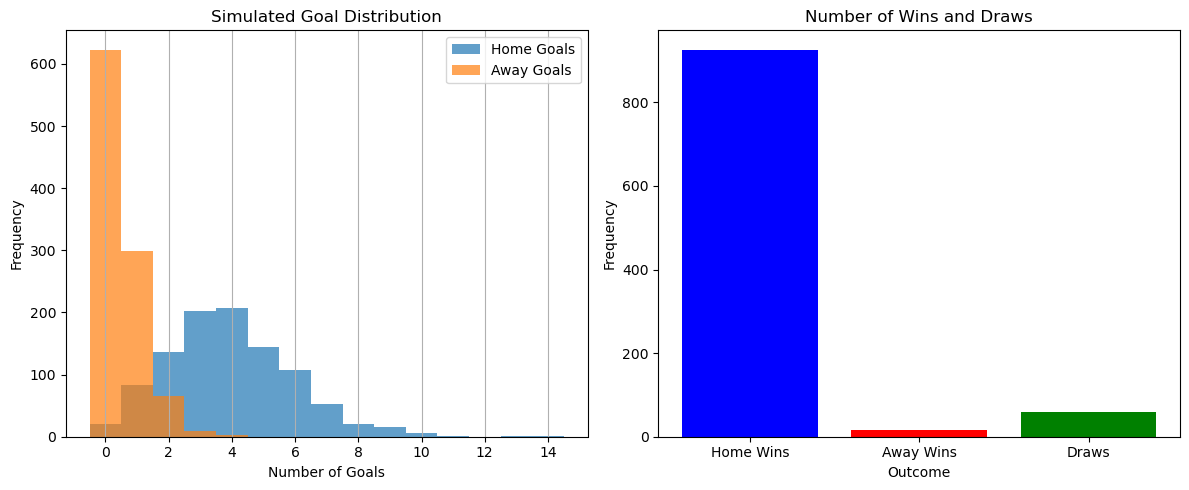

In [56]:
home_goals_simulated = np.random.poisson(home_goal_expectation, num_simulations)
away_goals_simulated = np.random.poisson(away_goal_expectation, num_simulations)

home_wins = np.sum(home_goals_simulated > away_goals_simulated)
away_wins = np.sum(home_goals_simulated < away_goals_simulated)
draws = np.sum(home_goals_simulated == away_goals_simulated)

# Plotting the distributions
plt.figure(figsize=(12, 5))

# Plotting goal distributions
plt.subplot(1, 2, 1)
plt.hist(home_goals_simulated, bins=np.arange(-0.5, max(home_goals_simulated) + 1.5, 1), alpha=0.7, label='Home Goals')
plt.hist(away_goals_simulated, bins=np.arange(-0.5, max(away_goals_simulated) + 1.5, 1), alpha=0.7, label='Away Goals')
plt.xlabel('Number of Goals')
plt.ylabel('Frequency')
plt.title('Simulated Goal Distribution')
plt.legend()
plt.grid(True, axis='x')

# Plotting win counts
plt.subplot(1, 2, 2)
labels = ['Home Wins', 'Away Wins', 'Draws']
values = [home_wins, away_wins, draws]
plt.bar(labels, values, color=['blue', 'red', 'green'])
plt.xlabel('Outcome')
plt.ylabel('Frequency')
plt.title('Number of Wins and Draws')

plt.tight_layout()
plt.show()

## Simulating the championship

In [57]:
sim = df[['Home', 'Away']].copy()
sim.head()

,Home,Away
0,Arsenal,Leicester
1,Brighton,Man City
2,Chelsea,Burnley
3,Crystal Palace,Huddersfield
4,Everton,Stoke


In [63]:
sim_matches_rs = simulate_season(sim, rs)
sim_standings_rs = calculate_standings(sim_matches_rs)
sim_standings_rs

,Pos,Team,PTS,P,W,D,L,GF,GA,GD,%
0,1,Man City,109,38,36,1,1,146,20,126,95.6
1,2,Man United,92,38,27,11,0,67,14,53,80.7
2,3,Liverpool,85,38,27,4,7,82,38,44,74.6
3,4,Chelsea,66,38,18,12,8,57,34,23,57.9
4,5,Tottenham,66,38,17,15,6,60,38,22,57.9
5,6,Leicester,57,38,14,15,9,58,53,5,50.0
6,7,Burnley,53,38,13,14,11,36,33,3,46.5
7,8,West Ham,52,38,16,4,18,60,73,-13,45.6
8,9,Arsenal,49,38,13,10,15,66,64,2,43.0
9,10,Crystal Palace,46,38,12,10,16,39,50,-11,40.4


## Simulating the championship 1000 times

In [64]:
all_standings = []
num_simulations = 100

for i in range(num_simulations):
    matches = simulate_season(sim, rs)
    standings = calculate_standings(matches)
    all_standings.append(standings)

# Now calculate the average standings
average_standings = pd.concat(all_standings).groupby('Team').mean().reset_index()

# Sort the average standings by Points, Goal Difference, and Goals For
average_standings = average_standings.sort_values(by=['PTS', 'GD', 'GF'], ascending=False)

# Add Position (Pos) column
average_standings['Pos'] = average_standings.index + 1
average_standings.set_index('Pos', inplace=True)
average_standings.index.name = 'Pos'
average_standings = average_standings[['Team', 'PTS', 'P', 'W', 'D', 'L', 'GF', 'GA', 'GD', '%']]
average_standings.reset_index(drop=True, inplace=True)

# Display the average standings
average_standings_rs = average_standings
average_standings_rs

,Team,PTS,P,W,D,L,GF,GA,GD,%
0,Man City,93.86,38.0,29.50,5.36,3.14,103.30,26.82,76.48,82.332
1,Liverpool,78.85,38.0,24.08,6.61,7.31,84.13,39.20,44.93,69.164
2,Man United,78.05,38.0,23.08,8.81,6.11,66.71,26.89,39.82,68.469
3,Tottenham,74.85,38.0,22.33,7.86,7.81,73.24,36.67,36.57,65.659
4,Chelsea,68.02,38.0,19.70,8.92,9.38,61.77,38.04,23.73,59.668
5,Arsenal,66.49,38.0,19.61,7.66,10.73,74.27,51.62,22.65,58.319
6,Leicester,50.71,38.0,14.09,8.44,15.47,55.99,61.85,-5.86,44.484
7,Burnley,50.41,38.0,13.11,11.08,13.81,35.94,38.63,-2.69,44.219
8,Crystal Palace,47.72,38.0,12.79,9.35,15.86,45.48,54.89,-9.41,41.859
9,Newcastle,45.67,38.0,11.79,10.30,15.91,37.66,46.82,-9.16,40.063


## Real standings

In [71]:
real_standings

,Pos,Team,PTS,P,W,D,L,GF,GA,GD,%
0,1,Man City,100,38,32,4,2,106,27,79,87.7
1,2,Man United,81,38,25,6,7,68,28,40,71.1
2,3,Tottenham,77,38,23,8,7,74,36,38,67.5
3,4,Liverpool,75,38,21,12,5,84,38,46,65.8
4,5,Chelsea,70,38,21,7,10,62,38,24,61.4
5,6,Arsenal,63,38,19,6,13,74,51,23,55.3
6,7,Burnley,54,38,14,12,12,36,39,-3,47.4
7,8,Everton,49,38,13,10,15,44,58,-14,43.0
8,9,Leicester,47,38,12,11,15,56,60,-4,41.2
9,10,Newcastle,44,38,12,8,18,39,47,-8,38.6


## Comparing Real and Sim standings

In [76]:
# Merge real_standings and sim_standings on 'Team' to compare attributes
comparison = pd.merge(real_standings, average_standings_rs, on='Team', suffixes=('_real', '_sim'))

# Calculate absolute differences for each attribute
attributes = ['PTS', 'W', 'D', 'L', 'GF', 'GA', 'GD', '%']
for attr in attributes:
    comparison[f'{attr}_diff'] = abs(comparison[f'{attr}_sim'] - comparison[f'{attr}_real'])

# Reorder columns for better readability (if needed)
comparison = comparison[['Team'] + [f'{attr}_real' for attr in attributes] + [f'{attr}_sim' for attr in attributes] + [f'{attr}_diff' for attr in attributes]]

diff_columns = [col for col in comparison.columns if col.endswith('_diff')]
diff_columns.append('Team')
comparison = comparison[diff_columns]
columns_order = ['Team'] + [col for col in comparison.columns if col != 'Team']
comparison = comparison[columns_order]
comparison.columns = comparison.columns.str.replace('_diff', '')

comparison_rs = comparison
comparison_rs

,Team,PTS,W,D,L,GF,GA,GD,%
0,Man City,6.14,2.50,1.36,1.14,2.70,0.18,2.52,5.368
1,Man United,2.95,1.92,2.81,0.89,1.29,1.11,0.18,2.631
2,Tottenham,2.15,0.67,0.14,0.81,0.76,0.67,1.43,1.841
3,Liverpool,3.85,3.08,5.39,2.31,0.13,1.20,1.07,3.364
4,Chelsea,1.98,1.30,1.92,0.62,0.23,0.04,0.27,1.732
5,Arsenal,3.49,0.61,1.66,2.27,0.27,0.62,0.35,3.019
6,Burnley,3.59,0.89,0.92,1.81,0.06,0.37,0.31,3.181
7,Everton,4.39,1.19,0.82,2.01,0.41,0.36,0.05,3.870
8,Leicester,3.71,2.09,2.56,0.47,0.01,1.85,1.86,3.284
9,Newcastle,1.67,0.21,2.30,2.09,1.34,0.18,1.16,1.463


# Final comparison

## Real standings

In [77]:
real_standings

,Pos,Team,PTS,P,W,D,L,GF,GA,GD,%
0,1,Man City,100,38,32,4,2,106,27,79,87.7
1,2,Man United,81,38,25,6,7,68,28,40,71.1
2,3,Tottenham,77,38,23,8,7,74,36,38,67.5
3,4,Liverpool,75,38,21,12,5,84,38,46,65.8
4,5,Chelsea,70,38,21,7,10,62,38,24,61.4
5,6,Arsenal,63,38,19,6,13,74,51,23,55.3
6,7,Burnley,54,38,14,12,12,36,39,-3,47.4
7,8,Everton,49,38,13,10,15,44,58,-14,43.0
8,9,Leicester,47,38,12,11,15,56,60,-4,41.2
9,10,Newcastle,44,38,12,8,18,39,47,-8,38.6


## Dixon Coles table

In [78]:
comparison_dc

,Team,PTS,W,D,L,GF,GA,GD,%
0,Man City,5.27,1.97,0.64,1.33,1.40,0.82,2.22,4.601
1,Man United,2.23,1.41,2.00,0.59,1.21,1.02,0.19,2.007
2,Tottenham,1.18,0.37,0.07,0.44,0.96,0.58,0.38,0.993
3,Liverpool,6.09,3.79,5.28,1.49,3.02,0.87,3.89,5.333
4,Chelsea,2.60,1.58,2.14,0.56,1.74,0.09,1.83,2.277
5,Arsenal,3.80,0.82,1.34,2.16,0.10,0.82,0.72,3.297
6,Burnley,6.25,1.89,0.58,2.47,1.64,0.00,1.64,5.510
7,Everton,3.18,0.80,0.78,1.58,0.71,0.20,0.91,2.813
8,Leicester,5.29,2.66,2.69,0.03,0.51,0.00,0.51,4.670
9,Newcastle,1.96,0.05,2.11,2.06,1.50,0.37,1.13,1.714


## Rue Salvesen table

In [79]:
comparison_rs

,Team,PTS,W,D,L,GF,GA,GD,%
0,Man City,6.14,2.50,1.36,1.14,2.70,0.18,2.52,5.368
1,Man United,2.95,1.92,2.81,0.89,1.29,1.11,0.18,2.631
2,Tottenham,2.15,0.67,0.14,0.81,0.76,0.67,1.43,1.841
3,Liverpool,3.85,3.08,5.39,2.31,0.13,1.20,1.07,3.364
4,Chelsea,1.98,1.30,1.92,0.62,0.23,0.04,0.27,1.732
5,Arsenal,3.49,0.61,1.66,2.27,0.27,0.62,0.35,3.019
6,Burnley,3.59,0.89,0.92,1.81,0.06,0.37,0.31,3.181
7,Everton,4.39,1.19,0.82,2.01,0.41,0.36,0.05,3.870
8,Leicester,3.71,2.09,2.56,0.47,0.01,1.85,1.86,3.284
9,Newcastle,1.67,0.21,2.30,2.09,1.34,0.18,1.16,1.463


## Points predictions

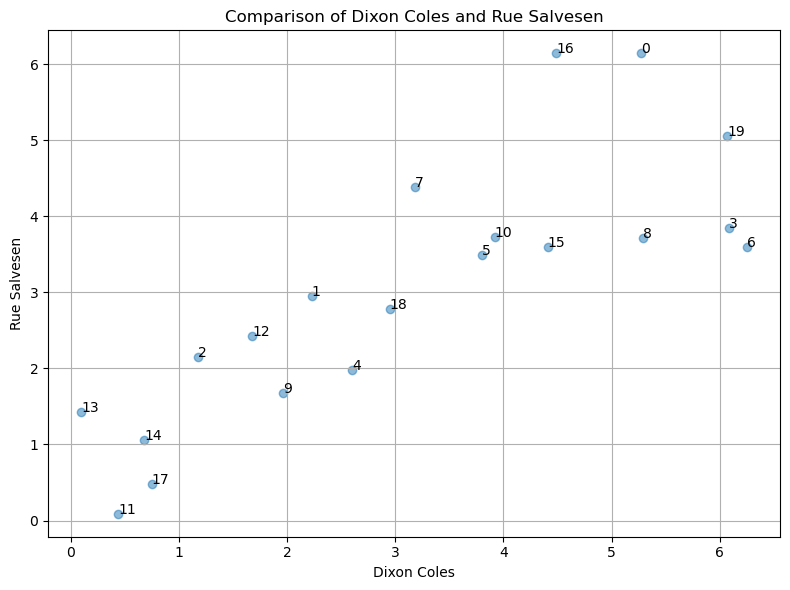

In [83]:
plt.figure(figsize=(8, 6))

plt.scatter(comparison_dc['PTS'], comparison_rs['PTS'], alpha=0.5)
plt.xlabel('Dixon Coles')
plt.ylabel('Rue Salvesen')
plt.title('Comparison of Dixon Coles and Rue Salvesen')
plt.grid(True)

# Annotate each point with the team name
for i, team in enumerate(comparison_dc.index):
    plt.text(comparison_dc['PTS'][i], comparison_rs['PTS'][i], team)

plt.tight_layout()
plt.show()

## Goals predictions

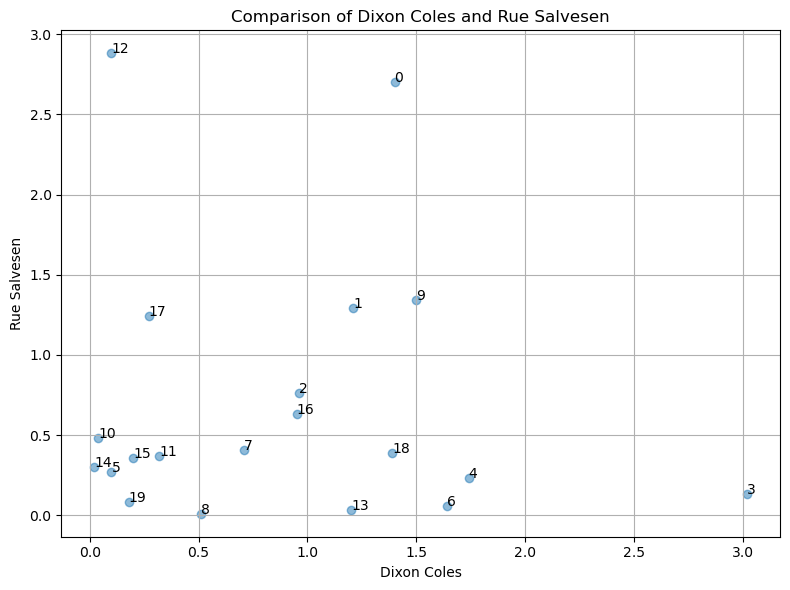

In [81]:
plt.figure(figsize=(8, 6))

plt.scatter(comparison_dc['GF'], comparison_rs['GF'], alpha=0.5)
plt.xlabel('Dixon Coles')
plt.ylabel('Rue Salvesen')
plt.title('Comparison of Dixon Coles and Rue Salvesen')
plt.grid(True)

# Annotate each point with the team name
for i, team in enumerate(comparison_dc.index):
    plt.text(comparison_dc['GF'][i], comparison_rs['GF'][i], team)

plt.tight_layout()
plt.show()